# GrabCutを使った対話的前景領域抽出
## 目的
このチュートリアルでは
* 画像の前景領域を抽出するためのGrabCutアルゴリズムについて学ぶ．
* この目的のために対話的アプリケーションを作成する．

## 理論
GrabCutアルゴリズムはイギリスのMicrosoft Research Cambridgeの研究者Carsten Rother, Vladimir Kolmogorov, & Andrew Blakeの論文 [“GrabCut”: interactive foreground extraction using iterated graph cuts](http://dl.acm.org/citation.cfm?id=1015720) で提案されたアルゴリズムである．ユーザーの作業の手間が小さい画像の前景領域抽出アルゴリズムが必要とされ，その答えがGrabCutである．

ユーザの観点で見ると、これはどのようなアルゴリズムなのだろうか? まず初めに初期値としてユーザーは前景領域の周りに長方形を描く(前景物体はこの長方形から飛び出してはいけない)．与えられた初期値を基に，GrabCutは処理を繰り返しながら前景の領域分割を行う．しかし，前景が背景に含まれたり，その逆であったり、というように分割がうまくいかない場合がある．そのような時は，結果をよくするためにユーザ入力が必要になる．領域分割に失敗した場所に線を描く．この線は， “背景(前景)に識別されたこの領域は前景(背景)だよ，次の繰り返し計算では修正してね” 、ということをプログラムに伝えるためのものである．これにより次の繰り返し計算でより良い結果が得られる．

下の画像を見てみよう．初めに、選手とボールを囲んで青い線が引かれている．また，前景を意味する白い線と、背景を意味する黒い線が入力されている点にも注意しよう．結果として，右側の画像のように良い結果が得られる．

![](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/grabcut_output1.jpg)

さて、この処理の内部では何が行われているのだろうか?

* ユーザが矩形を入力する．この矩形の外側にあるものは全て背景領域であるとみなされる(前景物体は全て矩形内に収まらなければならない、と書いた理由がこれである)．矩形内のものは全てが未知のものであると扱われる．同様に，ユーザ入力によって前景/背景と指定された領域はhard-labellingとして扱われ，以降の繰り返し処理でも値が変わらない領域になる．
* ユーザが入力したデータを基に初期のラベリングを行い，前景と背景に領域を分割する．
* 領域分割した前景と背景のモデルを作るために、混合正規分布(Gaussian Mixture Model(GMM))を使う．
* ユーザ入力と画像の画素値を基に，GMMは前景・背景の画素値の分布を学習する．未知の領域として設定された画素に対して，(クラスタリングのように)色の統計値を基に前景領域と背景領域との関係から前景らしさ，背景らしさを計算する．
* この画素値の分布からグラフを構築する．グラフのノードは画素に Source と Sink を加えたものになる．全ての前景画素はSourceノードに連結され，全ての背景画素はSinkノードに連結される．
* 画素とsource/sinkノードをつなぐエッジの重みは前景らしさ，背景らしさを表す確率によって定義される．画素間のエッジは画素の類似度や勾配情報によって定義される．隣接画素間に大きな画素値の差があれば，その画素をつなぐエッジの重みは低くなる．
* グラフの切断にmincutアルゴリズムを使う．mincutアルゴリズムはコスト関数を最小とするようにグラフをsource側とsink側に切断する．コスト関数は切断されたエッジの重みの合計値である．切断後にsourceノードに連結してある全画素は前景，sinkノードに連結してある全画素は背景領域の画素として認識される．
* この前景/背景の識別処理が収束するまで上記の処理を繰り返す．

以下の画像で示そう(画像引用: [http://www.cs.ru.ac.za/research/g02m1682/](http://www.cs.ru.ac.za/research/g02m1682/))

![](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/grabcut.jpg)

## デモ
それではOpenCVを使ったGrabCutアルゴリズムを使ってみよう．OpenCVは [cv2.grabCut(img, mask, rect, bgdModel, fgdModel, iterCount[, mode])](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/miscellaneous_transformations.html?highlight=cv2.grab#cv2.grabCut) という関数を用意している．引数は以下のようになる:

* img - 入力画像
* mask - マスク画像．背景，前景，背景らしい，前景らしい領域などを指定するためのマスク画像である．フラグとして `cv2.GC_BGD, cv2.GC_FGD, cv2.GC_PR_BGD, cv2.GC_PR_FGD` を指定するか，もしくは0,1,2,3のいずれかの数値を画像に与える(マスク画像中の画素値が0の画素は背景，1の画素は前景，2の画素は背景らしい，3の画素は前景らしい画素を意味する)．
* rect - 前景物体を囲む矩形領域．フォーマットは$(x,y,w,h)$で，矩形の左上の位置が$(x，y)$，サイズが$(w，h)$である．
* bdgModel, fgdModel - これらは内部のアルゴリズムで使用する配列である．サイズが$(1,65)$の`np.float64`型の配列を二つ用意する．
* iterCount - アルゴリズムの繰り返し計算の回数を表す．
* mode - 初期化の方法を指定するフラグである． `cv2.GC_INIT_WITH_RECT` か `cv2.GC_INIT_WITH_MASK` もしくは両方を指定する．それぞれ矩形領域内の情報を基に初期値を決めるか，前景/背景を指定する線を基に初期値を決めるかを表すフラグである．
ま
ず初めに `cv2.GC_INIT_WITH_RECT` フラグを指定した結果を見てみよう．画像を読み込み，似たようなマスク画像を作成する． fgdModel と bgdModel を作成する．矩形のパラメータを与える．ここまでは一本道である。次に繰り返し処理の回数を5回に設定し、モードは `cv2.GC_INIT_WITH_RECT` を指定する．設定が全て終わったので，GrabCutを走らせる．この結果，マスク画像は更新され、更新されたマスク画像内では画素は背景と前景を表す4つのどれかに分類される．画素値が0と2の画素は全て0(つまり背景)に，画素値が1と3の画素は全て1(つまり前景)に変更する．これで最終的なマスク画像が得られた．このマスク画像を入力画像に掛け算すれば領域分割された画像が得られる．([使用する画像](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_imgproc/py_grabcut/messi5.jpg))

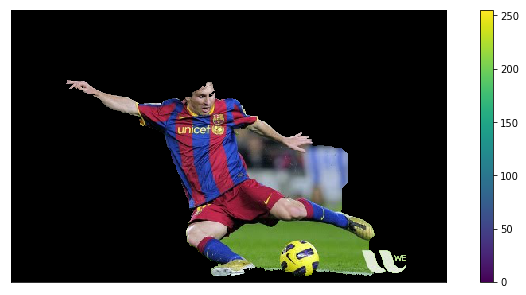

In [6]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('messi5.jpg')
mask = np.zeros(img.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

rect = (50,50,450,290)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]

img=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
plt.figure(figsize=(12,5))
plt.imshow(img),plt.colorbar()
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

おっと，メッシの髪の毛が背景になってしまった． 髪の毛の無いメッシなんて誰が望むだろうか? 髪の毛を取り戻そう．前景領域(画素値が1のフラグ)を追加で指定しよう．同時に前景として識別されているグラウンドやロゴも何とかしよう．これらの領域に0のフラグ(背景)を指定する．前のデモで得られたマスクを上記のように修正する．

私が実際何をしたかというと，ペイントツールを使って入力画像を開き，もう一つのレイヤーを追加した．ペイントのブラシツールを使い，未検出の前景領域(髪，靴，ボールなど)を白色にマークし，誤検出してしまった背景領域(ロゴやグラウンドなど)を黒色に設定した．それ以外の領域は灰色に設定する．次に，この作成したマスク画像をOpenCVで読み込み，オリジナルのマスク画像の対応する値を新しいマスク画像の値に置き換えた．以下のコードを参照のこと:([マスク画像](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_imgproc/py_grabcut/newmask.jpg)---注意:これは髪が消えたまま)

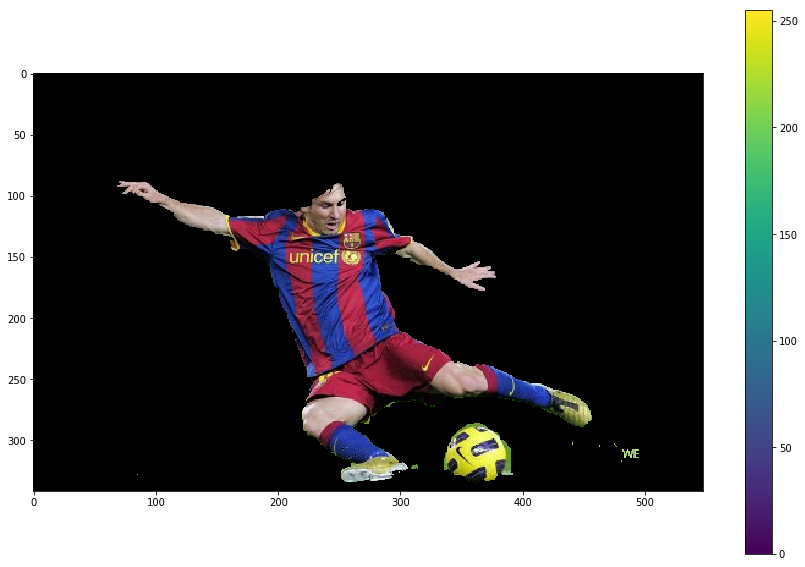

(<matplotlib.image.AxesImage at 0x7fbe70e6add8>,
 None)

In [7]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('messi5.jpg')
mask = np.zeros(img.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

rect = (50,50,450,290)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]

# newmask is the mask image I manually labelled
newmask = cv2.imread('newmask.jpg',0)

# whereever it is marked white (sure foreground), change mask=1
# whereever it is marked black (sure background), change mask=0
mask[newmask == 0] = 0
mask[newmask == 255] = 1

mask, bgdModel, fgdModel = cv2.grabCut(img,mask,None,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_MASK)

mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask[:,:,np.newaxis]
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,10))
plt.imshow(img),plt.colorbar(),plt.show()

ちなみに使用したマスク画像は以下:

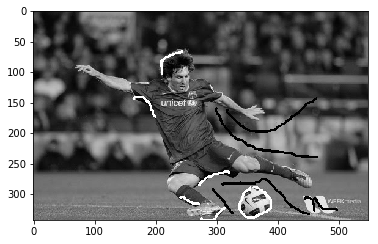

In [3]:
plt.imshow(newmask,'gray')

以上である．ここで、rectモードで初期化する代わりに，直接maskモードから始めることもできる．マスク画像中の矩形領域に2(背景らしい領域)と3(前景らしい領域)のフラグを指定し，二つ目の実装例で行ったように前景領域と確信できる領域をマークする．それからGrabCutアルゴリズムをmaskモードで走らせる．

## 課題
1. OpenCVのサンプルに含まれている [`grabcut.py`](https://github.com/opencv/opencv/blob/master/samples/python/grabcut.py) はGrabCutを使った対話ツールである．確認してみよう．使用方法については，[この YouTubeビデオ](http://www.youtube.com/watch?v=kAwxLTDDAwU) を参照のこと．
2. GrabCutアルゴリズムの対話的アプリケーションを作成しよう．アプリケーションでは，矩形領域と各領域の線をマウスで描き，線の太さをトラックバーで調整できるといった機能をつけてみよう．

参考: grabcut.py は以下の内容

In [ ]:
#!/usr/bin/env python
'''
===============================================================================
Interactive Image Segmentation using GrabCut algorithm.
This sample shows interactive image segmentation using grabcut algorithm.
USAGE:
    python grabcut.py <filename>
README FIRST:
    Two windows will show up, one for input and one for output.
    At first, in input window, draw a rectangle around the object using
mouse right button. Then press 'n' to segment the object (once or a few times)
For any finer touch-ups, you can press any of the keys below and draw lines on
the areas you want. Then again press 'n' for updating the output.
Key '0' - To select areas of sure background
Key '1' - To select areas of sure foreground
Key '2' - To select areas of probable background
Key '3' - To select areas of probable foreground
Key 'n' - To update the segmentation
Key 'r' - To reset the setup
Key 's' - To save the results
===============================================================================
'''

# Python 2/3 compatibility
from __future__ import print_function

import numpy as np
import cv2 as cv
import sys

BLUE = [255,0,0]        # rectangle color
RED = [0,0,255]         # PR BG
GREEN = [0,255,0]       # PR FG
BLACK = [0,0,0]         # sure BG
WHITE = [255,255,255]   # sure FG

DRAW_BG = {'color' : BLACK, 'val' : 0}
DRAW_FG = {'color' : WHITE, 'val' : 1}
DRAW_PR_FG = {'color' : GREEN, 'val' : 3}
DRAW_PR_BG = {'color' : RED, 'val' : 2}

# setting up flags
rect = (0,0,1,1)
drawing = False         # flag for drawing curves
rectangle = False       # flag for drawing rect
rect_over = False       # flag to check if rect drawn
rect_or_mask = 100      # flag for selecting rect or mask mode
value = DRAW_FG         # drawing initialized to FG
thickness = 3           # brush thickness

def onmouse(event,x,y,flags,param):
    global img,img2,drawing,value,mask,rectangle,rect,rect_or_mask,ix,iy,rect_over

    # Draw Rectangle
    if event == cv.EVENT_RBUTTONDOWN:
        rectangle = True
        ix,iy = x,y

    elif event == cv.EVENT_MOUSEMOVE:
        if rectangle == True:
            img = img2.copy()
            cv.rectangle(img,(ix,iy),(x,y),BLUE,2)
            rect = (min(ix,x),min(iy,y),abs(ix-x),abs(iy-y))
            rect_or_mask = 0

    elif event == cv.EVENT_RBUTTONUP:
        rectangle = False
        rect_over = True
        cv.rectangle(img,(ix,iy),(x,y),BLUE,2)
        rect = (min(ix,x),min(iy,y),abs(ix-x),abs(iy-y))
        rect_or_mask = 0
        print(" Now press the key 'n' a few times until no further change \n")

    # draw touchup curves

    if event == cv.EVENT_LBUTTONDOWN:
        if rect_over == False:
            print("first draw rectangle \n")
        else:
            drawing = True
            cv.circle(img,(x,y),thickness,value['color'],-1)
            cv.circle(mask,(x,y),thickness,value['val'],-1)

    elif event == cv.EVENT_MOUSEMOVE:
        if drawing == True:
            cv.circle(img,(x,y),thickness,value['color'],-1)
            cv.circle(mask,(x,y),thickness,value['val'],-1)

    elif event == cv.EVENT_LBUTTONUP:
        if drawing == True:
            drawing = False
            cv.circle(img,(x,y),thickness,value['color'],-1)
            cv.circle(mask,(x,y),thickness,value['val'],-1)

if __name__ == '__main__':

    # print documentation
    print(__doc__)

    # Loading images
    if len(sys.argv) == 2:
        filename = sys.argv[1] # for drawing purposes
    else:
        print("No input image given, so loading default image, ../data/lena.jpg \n")
        print("Correct Usage: python grabcut.py <filename> \n")
        filename = '../data/lena.jpg'

    img = cv.imread(filename)
    img2 = img.copy()                               # a copy of original image
    mask = np.zeros(img.shape[:2],dtype = np.uint8) # mask initialized to PR_BG
    output = np.zeros(img.shape,np.uint8)           # output image to be shown

    # input and output windows
    cv.namedWindow('output')
    cv.namedWindow('input')
    cv.setMouseCallback('input',onmouse)
    cv.moveWindow('input',img.shape[1]+10,90)

    print(" Instructions: \n")
    print(" Draw a rectangle around the object using right mouse button \n")

    while(1):

        cv.imshow('output',output)
        cv.imshow('input',img)
        k = cv.waitKey(1)

        # key bindings
        if k == 27:         # esc to exit
            break
        elif k == ord('0'): # BG drawing
            print(" mark background regions with left mouse button \n")
            value = DRAW_BG
        elif k == ord('1'): # FG drawing
            print(" mark foreground regions with left mouse button \n")
            value = DRAW_FG
        elif k == ord('2'): # PR_BG drawing
            value = DRAW_PR_BG
        elif k == ord('3'): # PR_FG drawing
            value = DRAW_PR_FG
        elif k == ord('s'): # save image
            bar = np.zeros((img.shape[0],5,3),np.uint8)
            res = np.hstack((img2,bar,img,bar,output))
            cv.imwrite('grabcut_output.png',res)
            print(" Result saved as image \n")
        elif k == ord('r'): # reset everything
            print("resetting \n")
            rect = (0,0,1,1)
            drawing = False
            rectangle = False
            rect_or_mask = 100
            rect_over = False
            value = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2],dtype = np.uint8) # mask initialized to PR_BG
            output = np.zeros(img.shape,np.uint8)           # output image to be shown
        elif k == ord('n'): # segment the image
            print(""" For finer touchups, mark foreground and background after pressing keys 0-3
            and again press 'n' \n""")
            if (rect_or_mask == 0):         # grabcut with rect
                bgdmodel = np.zeros((1,65),np.float64)
                fgdmodel = np.zeros((1,65),np.float64)
                cv.grabCut(img2,mask,rect,bgdmodel,fgdmodel,1,cv.GC_INIT_WITH_RECT)
                rect_or_mask = 1
            elif rect_or_mask == 1:         # grabcut with mask
                bgdmodel = np.zeros((1,65),np.float64)
                fgdmodel = np.zeros((1,65),np.float64)
                cv.grabCut(img2,mask,rect,bgdmodel,fgdmodel,1,cv.GC_INIT_WITH_MASK)

        mask2 = np.where((mask==1) + (mask==3),255,0).astype('uint8')
        output = cv.bitwise_and(img2,img2,mask=mask2)

    cv.destroyAllWindows()
    for _ in range(5):
        cv2.waitKey(1)


## 目次
* [最初に戻る]( http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/usingOpenCV.html )
* 一つ上: OpenCVを使った画像処理
OpenCVが提供する様々な画像処理の関数について学ぶ
* 前の学習項目: [Watershedアルゴリズムを使った画像の領域分割 watershed.ipynb]( http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/watershed.html)<BR>
Watershed algorithmによる画像の領域分割について学ぶ
* 次の学習項目: [特徴量検出と特徴量記述](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/feature2d.html )<BR>
特徴検出器，特徴量記述子について学ぶ 